# Zomato Case Study  
## Predict Kitchen Preparation Time

In [141]:
## Import necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline
sns.set_style('darkgrid')

# First step involves transforming the data from item_level to order_level
This has been accomplished by creating a list of item_names against each order_id and calcualting the item_count.

In [142]:
## Reading the csv file

df = pd.read_csv(open("/Users/praveenyadav/Downloads/test_data.csv"))

In [143]:
df.head(n=5)

,id,pickup_user_id,total_amount,pickup_user_address_id,created_at.x,ki,cost_for_two,created_at.y,driver_assigned_at,reached_shop_at,shipped_at,reached_customer_at,complete_at,linked_at,item_name
0,22437988,10345796,961.7,15530971,NaN,NaN,NaN,01/08/17 11:20,01/08/17 11:26,01/08/17 11:30,01/08/17 11:31,01/08/17 12:11,01/08/17 12:12,01/08/17 11:26,NaN
1,22437990,10670850,330.0,15982357,NaN,NaN,NaN,01/08/17 11:21,01/08/17 11:22,01/08/17 11:44,01/08/17 11:45,01/08/17 11:55,01/08/17 11:56,01/08/17 11:22,NaN
2,22438023,10348502,299.6,15534234,NaN,NaN,NaN,01/08/17 11:30,01/08/17 11:30,01/08/17 11:48,01/08/17 11:50,01/08/17 12:00,01/08/17 12:00,01/08/17 11:30,NaN
3,22438033,10889894,1965.2,16276686,NaN,NaN,NaN,01/08/17 11:33,01/08/17 11:57,01/08/17 11:59,01/08/17 12:49,01/08/17 13:27,01/08/17 13:27,01/08/17 11:57,NaN
4,22438037,10006319,314.0,15054245,NaN,NaN,NaN,01/08/17 11:35,01/08/17 11:35,01/08/17 11:48,01/08/17 11:57,01/08/17 12:18,01/08/17 12:18,01/08/17 11:35,NaN


# Exploratory Data Analysis and Feature Extraction

In [144]:
#df['item_name'] = df.apply(lambda row: row['item_name'] if row['item_name'].notnull() else "random_item", axis = 1)

df['item_name'] = np.where(df['item_name'].isnull(),"random_item",df['item_name'])

In [145]:
df.head(n=5)

,id,pickup_user_id,total_amount,pickup_user_address_id,created_at.x,ki,cost_for_two,created_at.y,driver_assigned_at,reached_shop_at,shipped_at,reached_customer_at,complete_at,linked_at,item_name
0,22437988,10345796,961.7,15530971,NaN,NaN,NaN,01/08/17 11:20,01/08/17 11:26,01/08/17 11:30,01/08/17 11:31,01/08/17 12:11,01/08/17 12:12,01/08/17 11:26,random_item
1,22437990,10670850,330.0,15982357,NaN,NaN,NaN,01/08/17 11:21,01/08/17 11:22,01/08/17 11:44,01/08/17 11:45,01/08/17 11:55,01/08/17 11:56,01/08/17 11:22,random_item
2,22438023,10348502,299.6,15534234,NaN,NaN,NaN,01/08/17 11:30,01/08/17 11:30,01/08/17 11:48,01/08/17 11:50,01/08/17 12:00,01/08/17 12:00,01/08/17 11:30,random_item
3,22438033,10889894,1965.2,16276686,NaN,NaN,NaN,01/08/17 11:33,01/08/17 11:57,01/08/17 11:59,01/08/17 12:49,01/08/17 13:27,01/08/17 13:27,01/08/17 11:57,random_item
4,22438037,10006319,314.0,15054245,NaN,NaN,NaN,01/08/17 11:35,01/08/17 11:35,01/08/17 11:48,01/08/17 11:57,01/08/17 12:18,01/08/17 12:18,01/08/17 11:35,random_item


In [146]:
grouped_df_new = df.groupby('id').agg({'item_name': lambda x: list(x),
                                        'pickup_user_id' : "mean",
                                        'total_amount' : "mean",
                                        'cost_for_two' : "mean",
                                        'created_at.y' : "min",
                                        'driver_assigned_at' : "min",
                                        'reached_shop_at' : "min",
                                        'shipped_at' : "min",
                                        'linked_at' : "min"})

In [147]:
grouped_df_new["item_count"] = grouped_df_new.apply(lambda row : len(row["item_name"]), axis = 1)

## Imputing missing values in item_name (the toughest part)
We have initially assigned "random_item" to all the missing values. Now, we have grouped the data based on total_amount within buckets of 1000 and observe the most occuring "item_name" list (of a particular length of a list) and will impute that "item_name" list against the missing value (of that particular length of "item_name" list). I have created the bucket of size 1000 hence so many cases, these cases can be redued if we increase the bucket size but then it will also lead to a loss in accuracy

In [148]:
most_common_item = {"0-1000" : {}, "1001-2000" : {}, "2001-3000" : {}, ">3000" : {}}


for row in grouped_df_new.iterrows():
    if row[1]["total_amount"] > 0 and row[1]["total_amount"] < 1001 :
        if str(len(row[1]["item_name"])) not in most_common_item["0-1000"]:
            most_common_item["0-1000"][str(len(row[1]["item_name"]))] = {}
        else:
            if str(row[1]["item_name"]) not in most_common_item["0-1000"][str(len(row[1]["item_name"]))]:
                most_common_item["0-1000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] = 1
            else : 
                most_common_item["0-1000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] += 1
    if row[1]["total_amount"] > 1000 and row[1]["total_amount"] < 2001 :
        if str(len(row[1]["item_name"])) not in most_common_item["1001-2000"]:
            most_common_item["1001-2000"][str(len(row[1]["item_name"]))] = {}
        else:
            if str(row[1]["item_name"]) not in most_common_item["1001-2000"][str(len(row[1]["item_name"]))]:
                most_common_item["1001-2000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] = 1
            else : 
                most_common_item["1001-2000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] += 1
    if row[1]["total_amount"] > 2000 and row[1]["total_amount"] < 3001 :
        if str(len(row[1]["item_name"])) not in most_common_item["2001-3000"]:
            most_common_item["2001-3000"][str(len(row[1]["item_name"]))] = {}
        else:
            if str(row[1]["item_name"]) not in most_common_item["2001-3000"][str(len(row[1]["item_name"]))]:
                most_common_item["2001-3000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] = 1
            else : 
                most_common_item["2001-3000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] += 1
    if row[1]["total_amount"] > 3000 : 
        if str(len(row[1]["item_name"])) not in most_common_item[">3000"]:
            most_common_item[">3000"][str(len(row[1]["item_name"]))] = {}
        else:
            if str(row[1]["item_name"]) not in most_common_item[">3000"][str(len(row[1]["item_name"]))]:
                most_common_item[">3000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] = 1
            else : 
                most_common_item[">3000"][str(len(row[1]["item_name"]))][tuple(row[1]["item_name"])] += 1


In [149]:
## Deleting "random_item" from each dict
for keys, value in most_common_item.items():
    for key, val in value.items():
        for ke,va in val.items():
            if list(ke)[0] == "random_item":
                del val[ke]
                
## sorting the dictionary to store the most common item
sorted_most_common_item = {}
for keys, value in most_common_item.items():
    sorted_most_common_item[keys] = {}
    for key, val in value.items():
        sorted_most_common_item[keys][key] = {}
        max_val = 0
        for ke,va in val.items():
            if max_val < va:
                max_val = va
                max_key = ke
            else:
                pass
        sorted_most_common_item[keys][key] = max_key



In [150]:
def func_item(row):
    if row["item_name"][0] == "random_item":
        if row["total_amount"] > 0 and row["total_amount"] < 1001:
            row["item_name"] = list(sorted_most_common_item["0-1000"][str(len(row["item_name"]))])
        elif row["total_amount"] > 1000 and row["total_amount"] < 2001:
            row["item_name"] = list(sorted_most_common_item["1001-2000"][str(len(row["item_name"]))])
        elif row["total_amount"] > 2000 and row["total_amount"] < 3001:
            row["item_name"] = list(sorted_most_common_item["2001-3000"][str(len(row["item_name"]))])
        elif row["total_amount"] > 3000:
            row["item_name"] = list(sorted_most_common_item[">3000"][str(len(row["item_name"]))])
    else:
        row["item_name"] = row["item_name"]
    return row["item_name"]
    
grouped_df_new["item_name"] = grouped_df_new.apply(lambda row: func_item(row),axis = 1)

In [151]:
grouped_df_new.head(n=5)

,cost_for_two,reached_shop_at,total_amount,driver_assigned_at,item_name,linked_at,pickup_user_id,shipped_at,created_at.y,item_count
id,,,,,,,,,,
22437988,NaN,01/08/17 11:30,961.7,01/08/17 11:26,[Mix Vegetable],01/08/17 11:26,10345796,01/08/17 11:31,01/08/17 11:20,1
22437990,NaN,01/08/17 11:44,330.0,01/08/17 11:22,[Mix Vegetable],01/08/17 11:22,10670850,01/08/17 11:45,01/08/17 11:21,1
22438023,NaN,01/08/17 11:48,299.6,01/08/17 11:30,[Mix Vegetable],01/08/17 11:30,10348502,01/08/17 11:50,01/08/17 11:30,1
22438033,NaN,01/08/17 11:59,1965.2,01/08/17 11:57,[Kadai Murgh [3 Pieces]],01/08/17 11:57,10889894,01/08/17 12:49,01/08/17 11:33,1
22438037,NaN,01/08/17 11:48,314.0,01/08/17 11:35,[Mix Vegetable],01/08/17 11:35,10006319,01/08/17 11:57,01/08/17 11:35,1


## Removing and Imputing null values of "cost_for_two" column
#### Since we have to predict the kitchen preparation time, I focussed on details concerning kitchen and item and neglected the details of driver and after shipping details. After generating the dataset it was seen that there are lot of missing values in "cost_for_two" and "item_name". Since it was difficult to impute the missing values in shipped_at and linked_at column, I had to remove those rows and it was not costly since there were not too many of them

In [152]:
group_filtered_df = grouped_df_new[(grouped_df_new['shipped_at'].notnull()) & (grouped_df_new['linked_at'].notnull())]

In [153]:
group_filtered_df.head(n=5)

,cost_for_two,reached_shop_at,total_amount,driver_assigned_at,item_name,linked_at,pickup_user_id,shipped_at,created_at.y,item_count
id,,,,,,,,,,
22437988,NaN,01/08/17 11:30,961.7,01/08/17 11:26,[Mix Vegetable],01/08/17 11:26,10345796,01/08/17 11:31,01/08/17 11:20,1
22437990,NaN,01/08/17 11:44,330.0,01/08/17 11:22,[Mix Vegetable],01/08/17 11:22,10670850,01/08/17 11:45,01/08/17 11:21,1
22438023,NaN,01/08/17 11:48,299.6,01/08/17 11:30,[Mix Vegetable],01/08/17 11:30,10348502,01/08/17 11:50,01/08/17 11:30,1
22438033,NaN,01/08/17 11:59,1965.2,01/08/17 11:57,[Kadai Murgh [3 Pieces]],01/08/17 11:57,10889894,01/08/17 12:49,01/08/17 11:33,1
22438037,NaN,01/08/17 11:48,314.0,01/08/17 11:35,[Mix Vegetable],01/08/17 11:35,10006319,01/08/17 11:57,01/08/17 11:35,1


#### Since there were only 2846 unique restaurants, I generated a mapping of restaurant and cost_for_two parameter and imputed its values in the order_id with that restaurant against the cost_for_two. For the remaining missing values I simply imputed them with the mean of the cost_for_two column

In [154]:
## Generating a mapping of restaurant and its cost_for_two parameter to fill the missing values

len(group_filtered_df.pickup_user_id.unique())

cost_dict = {}
for row in group_filtered_df.iterrows():
    cost_dict[row[1]['pickup_user_id']] = row[1]['cost_for_two']


In [155]:
group_filtered_df['cost_for_two'] = group_filtered_df.apply(lambda row : cost_dict[row['pickup_user_id']], axis =1)

## Valid rows length after imputation = 179593

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [156]:
group_filtered_df['cost_for_two'] = group_filtered_df.apply(lambda row:  group_filtered_df['cost_for_two'].mean()
                                                            if np.isnan(row['cost_for_two']) else row['cost_for_two']
                                                            , axis = 1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### New Feature "kpt_time" which is defined as the difference between shipped_at and linked_at

In [157]:
## Calculating the time for the driver to reach the restaurant and the kitchen preparation time

def time_diff(start,end):
    fmt = '%H:%M'
    diff = int(round((datetime.strptime(end,fmt) - datetime.strptime(start,fmt)).total_seconds() /60))
    return diff
  
group_filtered_df["kpt_time"] = group_filtered_df.apply(lambda row: time_diff(row['linked_at'].split(" ")[1], 
                                                                    row['shipped_at'].split(" ")[1]), axis=1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [158]:
group_filtered_df.describe()

,cost_for_two,total_amount,pickup_user_id,item_count,kpt_time
count,195202.000000,195202.000000,1.952020e+05,195202.000000,195202.000000
mean,600.674581,443.634656,1.143350e+07,2.478981,23.408894
std,286.666698,413.397741,1.720084e+05,2.044051,19.501805
min,100.000000,30.000000,9.678620e+06,1.000000,-1374.000000
25%,400.000000,220.000000,1.132635e+07,1.000000,14.000000
50%,550.000000,325.000000,1.145773e+07,2.000000,21.000000
75%,700.000000,518.290000,1.153533e+07,3.000000,29.000000
max,5000.000000,29070.480000,1.176280e+07,60.000000,295.000000


# Removing Outliers
Detecting the outliers with the help of describe() function. Since most of the data is captured under the below conditions and outliers in this case are not significant to preserve, I removed all of them

In [159]:
## Removing outliers from the data 

group_filtered_df_rem_out = group_filtered_df[(group_filtered_df['kpt_time'] > 0) &
                                              (group_filtered_df['total_amount'] < 5000) &
                                              (group_filtered_df['item_count'] < 20) &
                                              (group_filtered_df['kpt_time'] < 80)]


In [160]:
group_filtered_df_rem_out.describe()

,cost_for_two,total_amount,pickup_user_id,item_count,kpt_time
count,193627.000000,193627.000000,1.936270e+05,193627.000000,193627.000000
mean,600.704118,438.404369,1.143356e+07,2.442443,23.089590
std,286.423034,371.116891,1.720370e+05,1.854375,12.327726
min,100.000000,30.000000,9.678620e+06,1.000000,1.000000
25%,400.000000,219.935000,1.132635e+07,1.000000,14.000000
50%,550.000000,325.000000,1.145773e+07,2.000000,21.000000
75%,700.000000,516.195000,1.153542e+07,3.000000,29.000000
max,5000.000000,4989.450000,1.176280e+07,18.000000,79.000000


# Data Visualisation using matplotlib
Using histogram and scatter plots we expect to identify the significance of each feature in determining the kitchen preparation time.

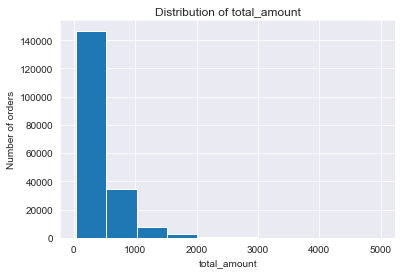

In [161]:
group_filtered_df_rem_out.total_amount.hist()
plt.title("Distribution of total_amount")
plt.xlabel("total_amount")
plt.ylabel("Number of orders")
plt.show()
#sns.kdeplot(final_list.total_amount, shade = True)
#sns.boxplot(final_list.total_amount, color = 'green', orient = 'v')

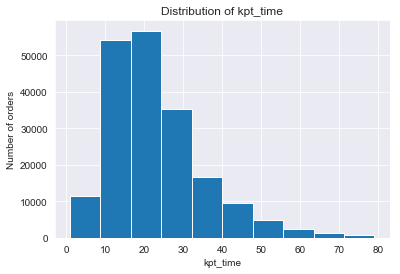

In [162]:
group_filtered_df_rem_out.kpt_time.hist()
plt.title("Distribution of kpt_time")
plt.xlabel("kpt_time")
plt.ylabel("Number of orders")
plt.show()

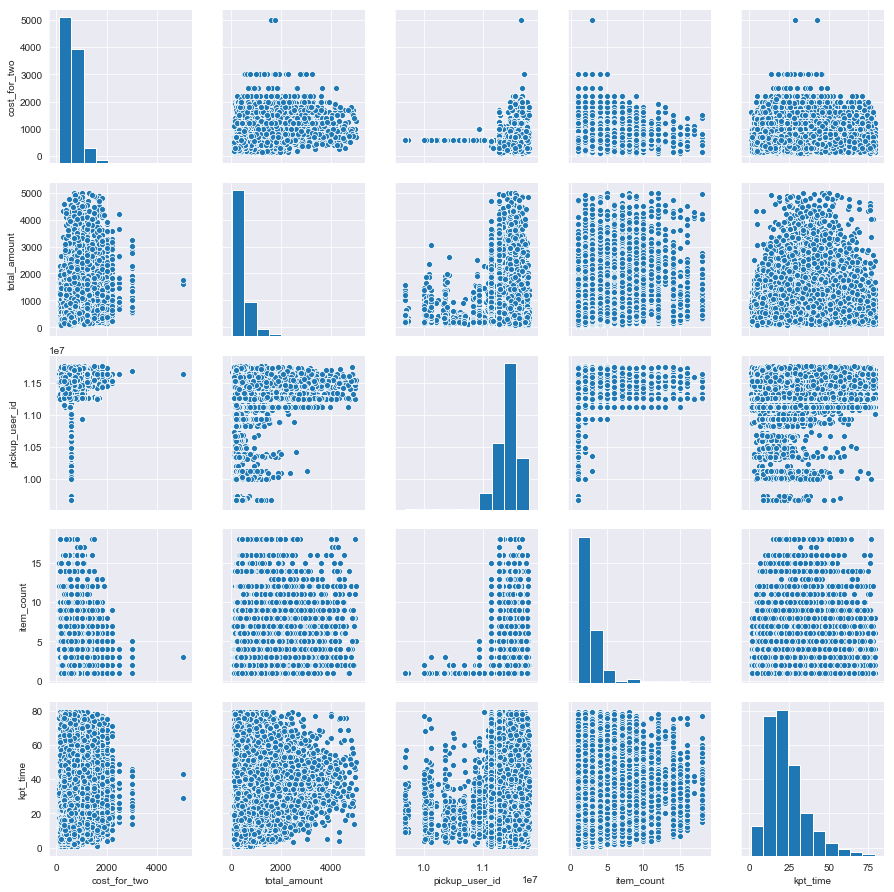

In [163]:
## Scatter Plots to understand the relation between dependent and independent variables

sns.pairplot(group_filtered_df_rem_out)

## Correlation Heatmaps
After generating the heatmaps, we see that kpt_time is mostly affected by total_amount, then item_count and lastly by kitchen parameter (cost_for_two) which largely aligns with our initial guess

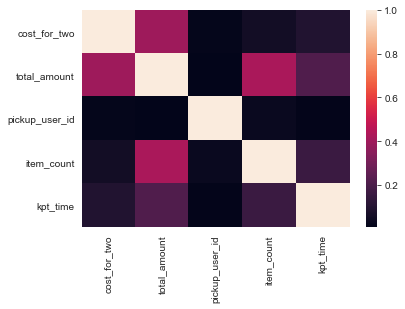

In [164]:
corr = group_filtered_df_rem_out.corr()
sns.heatmap(corr)


## Encoding the linked_at feature and item_name
There is a direct relationship between the kitchen preparation time and order linked_at time, since during the peak hours there might be lot of orders which might result into a longer preparation time. Hence, to use it in the regression model I encoded the linked_at time into linked_time_interval which was generated with the help of linked_time_interval_map mapping

In [165]:
## One hot encoding the categorical variable "linked_at" to understand 
##the effect of linked_time on the kitchen preparation time

linked_time_interval_map = {"11" : "1112", "12" : "1213", "13" : "1314", "14": "1415",
                            "15" : "1516", "16" : "1617", "17" : "1718", "18" : "1819",
                            "19" : "1920", "20" : "2021", "21" : "2122", "22" : "2223",
                            "23" : "2324", "0" : "01", "1" : "12", "2" : "23", "3" : "34",
                            "4" : "45", "5" : "56", "6" : "67", "7" : "78", "8" : "89",
                            "9" : "910", "10" : "1011"}
group_filtered_df_rem_out['linked_time_interval'] = group_filtered_df_rem_out.apply(lambda row: 
                                                linked_time_interval_map[row['linked_at'].split(" ")[1].split(":")[0]]
                                                                                    , axis=1)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [166]:
group_filtered_df_rem_out.head(n=5)

,cost_for_two,reached_shop_at,total_amount,driver_assigned_at,item_name,linked_at,pickup_user_id,shipped_at,created_at.y,item_count,kpt_time,linked_time_interval
id,,,,,,,,,,,,
22437988,600.674581,01/08/17 11:30,961.7,01/08/17 11:26,[Mix Vegetable],01/08/17 11:26,10345796,01/08/17 11:31,01/08/17 11:20,1,5,1112
22437990,600.674581,01/08/17 11:44,330.0,01/08/17 11:22,[Mix Vegetable],01/08/17 11:22,10670850,01/08/17 11:45,01/08/17 11:21,1,23,1112
22438023,600.674581,01/08/17 11:48,299.6,01/08/17 11:30,[Mix Vegetable],01/08/17 11:30,10348502,01/08/17 11:50,01/08/17 11:30,1,20,1112
22438033,600.674581,01/08/17 11:59,1965.2,01/08/17 11:57,[Kadai Murgh [3 Pieces]],01/08/17 11:57,10889894,01/08/17 12:49,01/08/17 11:33,1,52,1112
22438037,600.674581,01/08/17 11:48,314.0,01/08/17 11:35,[Mix Vegetable],01/08/17 11:35,10006319,01/08/17 11:57,01/08/17 11:35,1,22,1112


In [ ]:
## One hot encoding the item_name column using get_dummies()

group_filtered_df_rem_out.drop('item_name', 1).join(group_filtered_df_rem_out.item_name.str.join('|').str.get_dummies())


In [66]:
group_filtered_df_rem_out_new.head(n=5)

,cost_for_two,reached_shop_at,total_amount,driver_assigned_at,item_name,linked_at,pickup_user_id,shipped_at,created_at.y,item_count,kpt_time,linked_time_interval
id,,,,,,,,,,,,
22437988,600.674581,01/08/17 11:30,961.7,01/08/17 11:26,[nan],01/08/17 11:26,10345796,01/08/17 11:31,01/08/17 11:20,1,5,1112
22437990,600.674581,01/08/17 11:44,330.0,01/08/17 11:22,[nan],01/08/17 11:22,10670850,01/08/17 11:45,01/08/17 11:21,1,23,1112
22438023,600.674581,01/08/17 11:48,299.6,01/08/17 11:30,[nan],01/08/17 11:30,10348502,01/08/17 11:50,01/08/17 11:30,1,20,1112
22438033,600.674581,01/08/17 11:59,1965.2,01/08/17 11:57,[nan],01/08/17 11:57,10889894,01/08/17 12:49,01/08/17 11:33,1,52,1112
22438037,600.674581,01/08/17 11:48,314.0,01/08/17 11:35,[nan],01/08/17 11:35,10006319,01/08/17 11:57,01/08/17 11:35,1,22,1112


# Feature Selection for training regression models
Since kitchen preparation time is only dependent on kitchen parameters (cost_for_two) and order parameters (total_amount, item_count and linked_time_interval), the rest of the columns were eliminated

In [ ]:
column_drop = ["reached_shop_at", "driver_assigned_at", "item_name", "linked_at", "shipped_at",
               "created_at.y", "pickup_user_id"]
final_df = group_filtered_df_rem_out_new.drop(column_drop, axis = 1)

In [68]:
final_df.head(n=5)

,cost_for_two,total_amount,item_count,kpt_time,linked_time_interval
id,,,,,
22437988,600.674581,961.7,1,5,1112
22437990,600.674581,330.0,1,23,1112
22438023,600.674581,299.6,1,20,1112
22438033,600.674581,1965.2,1,52,1112
22438037,600.674581,314.0,1,22,1112


### Since cost_for_two and total_amount were right skewed, I transformed the features by taking log to give probably a much better symmetrical distribution

In [ ]:
skewed = ['cost_for_two', 'total_amount']
final_df_log_transformed = pd.DataFrame(data = final_df)
final_df_log_transformed[skewed] = final_df[skewed].apply(lambda x: np.log(x + 1))

# ## Normalizing Numerical Features

# scaler = MinMaxScaler()

# numerical = ["cost_for_two", "total_amount"]
# final_df_minmax_transform = pd.DataFrame(data = final_df)
# final_df_minmax_transform[numerical] = scaler.fit_transform(final_df[numerical])

# Creating training and testing set using train_test_split

In [70]:
## Training the Prediction models

features = final_df_log_transformed.drop("kpt_time", axis = 1)
output = final_df_log_transformed["kpt_time"]

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    output, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 154901 samples.
Testing set has 38726 samples.


# Training the data on regression models (LinearRegression, RandomForestRegressor and Ridge Regression) 
Fit, predict and evaluate the preformance of the model. I tried to also use SVM but it somehow hanged the notebook everytime and hence I had to remove it

In [74]:
## Training Linear Regression Model

model = LinearRegression()
model.fit(X_train,y_train)

prediction_linear_model = model.predict(X_test)
print(prediction_linear_model)
accuracy = mean_absolute_error(y_test,prediction_linear_model)
print("Accuracy of the model is",format(accuracy))

[ 21.26418259  22.03750583  33.62296008 ...,  20.46309393  26.86398646
  23.44879885]
9.09758286628


In [ ]:
## Training Random Forest Regressor Model

model = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = 0)
model.fit(X_train,y_train)

prediction_linear_model = model.predict(X_test)
print(prediction_linear_model)
accuracy = mean_absolute_error(y_test,prediction_linear_model)
print("Accuracy of the model is",format(accuracy))

In [77]:
## Training Ridge Regression Model

model = Ridge(alpha = 1.0)
model.fit(X_train,y_train)

prediction_linear_model = model.predict(X_test)
print(prediction_linear_model)
accuracy = mean_absolute_error(y_test,prediction_linear_model)
print("Accuracy of the model is",format(accuracy))

[ 21.26418587  22.03749833  33.62292701 ...,  20.46314513  26.86394917
  23.44877615]
9.09758350201
